In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hideblur/HIDE_dataset/Quantity-crowded.txt
/kaggle/input/hideblur/HIDE_dataset/Depth-close-up.txt
/kaggle/input/hideblur/HIDE_dataset/test.txt
/kaggle/input/hideblur/HIDE_dataset/Depth-long-shot.txt
/kaggle/input/hideblur/HIDE_dataset/readme.txt
/kaggle/input/hideblur/HIDE_dataset/Quantity-scattered.txt
/kaggle/input/hideblur/HIDE_dataset/train.txt
/kaggle/input/hideblur/HIDE_dataset/GT/86fromGOPR1093.MP4.png
/kaggle/input/hideblur/HIDE_dataset/GT/63fromGOPR1092.MP4.png
/kaggle/input/hideblur/HIDE_dataset/GT/160fromGOPR1040.MP4.png
/kaggle/input/hideblur/HIDE_dataset/GT/4fromGOPR1033.MP4.png
/kaggle/input/hideblur/HIDE_dataset/GT/202fromGOPR1098.MP4.png
/kaggle/input/hideblur/HIDE_dataset/GT/125fromGOPR1078.MP4.png
/kaggle/input/hideblur/HIDE_dataset/GT/208fromGOPR1081.MP4.png
/kaggle/input/hideblur/HIDE_dataset/GT/89fromGOPR1042.MP4.png
/kaggle/input/hideblur/HIDE_dataset/GT/100fromGOPR1095.MP4.png
/kaggle/input/hideblur/HIDE_dataset/GT/26fromGOPR1030.MP4.png
/kaggle/inp

In [1]:
import tensorflow as tf

print("GPUs Available:", tf.config.list_physical_devices('GPU'))
blurry_dir = "/kaggle/input/hideblur/HIDE_dataset/train"
sharp_dir  = "/kaggle/input/hideblur/HIDE_dataset/GT"

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [1]:
#%%
import tensorflow as tf
import numpy as np
import os
import glob

# Enable multi-GPU strategy
strategy = tf.distribute.MirroredStrategy()
print(f"Using {strategy.num_replicas_in_sync} GPUs")

# Set mixed precision for faster training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

optimizer = tf.keras.optimizers.Adam()
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

# Define image size and batch size
IMG_SIZE = (512, 512)  # Updated to 512x512
BATCH_SIZE = 8  # Reduce batch size due to higher memory usage
NUM_IMAGES = 1000  # Use 5000 image pairs for training

#%% [code]
# Set dataset directories
blurry_dir = "/kaggle/input/hideblur/HIDE_dataset/train"
sharp_dir  = "/kaggle/input/hideblur/HIDE_dataset/GT"

# Get file paths
blurry_files = sorted(glob.glob(os.path.join(blurry_dir, "*.png")))
sharp_files  = sorted(glob.glob(os.path.join(sharp_dir, "*.png")))

# Match pairs
blurry_fnames = set([os.path.basename(p) for p in blurry_files])
sharp_fnames  = set([os.path.basename(p) for p in sharp_files])
common_fnames = sorted(list(blurry_fnames.intersection(sharp_fnames)))

print("Found", len(common_fnames), "matching pairs.")

# Use only first NUM_IMAGES pairs
common_fnames = common_fnames[:NUM_IMAGES]

# Full paths
blurry_paths = [os.path.join(blurry_dir, fname) for fname in common_fnames]
sharp_paths  = [os.path.join(sharp_dir, fname) for fname in common_fnames]

#%% [code]
# Preprocessing
def preprocess_image(image_path, label_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize

    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=3)
    label = tf.image.resize(label, IMG_SIZE)
    label = tf.cast(label, tf.float32) / 255.0

    return image, label

# Augmentation
def augment(image, label):
    seed = tf.random.uniform(shape=(), maxval=100000, dtype=tf.int32)
    image = tf.image.stateless_random_flip_left_right(image, seed=[seed, 0])
    label = tf.image.stateless_random_flip_left_right(label, seed=[seed, 0])

    image = tf.image.stateless_random_flip_up_down(image, seed=[seed, 1])
    label = tf.image.stateless_random_flip_up_down(label, seed=[seed, 1])

    return image, label

# Create dataset
def create_dataset(blurry_paths, sharp_paths, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((blurry_paths, sharp_paths))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

train_dataset = create_dataset(blurry_paths, sharp_paths, BATCH_SIZE)

# Debug: print batch shape
for imgs, labs in train_dataset.take(1):
    print("Blurry batch shape:", imgs.shape, "Sharp batch shape:", labs.shape)

#%% [code]
# Updated U-Net model for 512x512 images
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

def unet_model(input_shape=(512,512,3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)  # 256x256

    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)  # 128x128

    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)  # 64x64

    c4 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)  # 32x32

    # Bottleneck
    c5 = layers.Conv2D(1024, (3,3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3,3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.UpSampling2D((2,2))(c5)  # 32x32 → 64x64
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2,2))(c6)  # 64x64 → 128x128
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c7)

    u8 = layers.UpSampling2D((2,2))(c7)  # 128x128 → 256x256
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c8)

    u9 = layers.UpSampling2D((2,2))(c8)  # 256x256 → 512x512
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(3, (1,1), activation='sigmoid')(c9)

    return Model(inputs, outputs)

with strategy.scope():
    model = unet_model()
    model.compile(optimizer="adam", loss=SSIMLoss, metrics=["accuracy"])
model.summary()

# Train
# checkpoint = ModelCheckpoint("best_deblur_model_512.keras", monitor='loss', save_best_only=True, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.7, patience=5, verbose=1)

# epochs = 30
# steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
# model.fit(train_dataset, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=[checkpoint, reduce_lr])


Using 2 GPUs
Found 6397 matching pairs.
Blurry batch shape: (8, 512, 512, 3) Sharp batch shape: (8, 512, 512, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 512, 512, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 64)   │          1,792 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 128)  │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 256)  │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 256)  │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 64, 64, 1024)   │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├──────────────────────

 Total params: 31,379,075 (119.70 MB)

 Trainable params: 31,379,075 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
import os
print(os.listdir("/kaggle/working/"))

['.virtual_documents', 'best_deblur_model_512.keras']


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


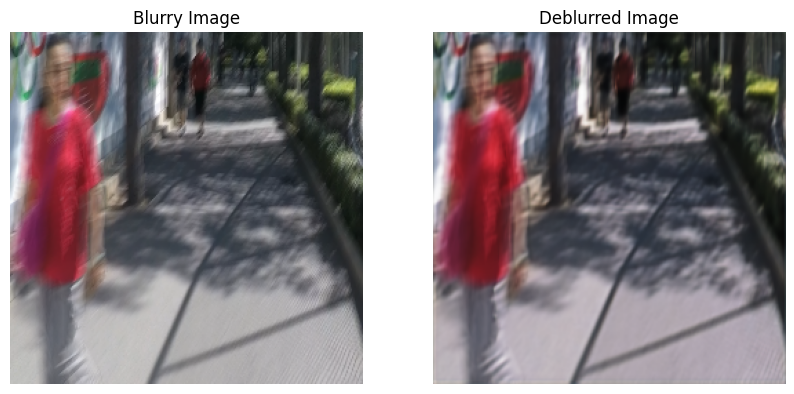

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

IMG_SIZE = (256, 256)

# Function to load and preprocess an image
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return tf.expand_dims(image, axis=0)  # Add batch dimension

# Path to a test blurry image
test_image_path = "/kaggle/input/hideblur/HIDE_dataset/train/100fromGOPR1034.MP4.png"

# Load and preprocess the test image
input_image = load_image(test_image_path)
# Predict using the model
output_image = model.predict(input_image)[0]  # Remove batch dimension
import numpy as np
import matplotlib.pyplot as plt

# Ensure the output image is in a valid format
output_image = np.clip(output_image, 0, 1)  # Ensure values are in [0,1]
output_image = (output_image * 255).astype(np.uint8)  # Convert to [0,255] uint8

# Ensure input image is in a valid format
input_image = input_image[0].numpy()  # Convert tensor to numpy
input_image = (input_image * 255).astype(np.uint8)  # Convert to uint8

# Plot original vs deblurred image
plt.figure(figsize=(10, 5))

# Original blurry image
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title("Blurry Image")
plt.axis("off")

# Deblurred output
plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title("Deblurred Image")
plt.axis("off")

plt.show()

In [8]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import keras

# Define the SSIM loss function
def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# Register the function to make it loadable
keras.utils.get_custom_objects()["SSIMLoss"] = SSIMLoss

# Define model path
MODEL_PATH = "/kaggle/working/best_deblur_model_3000_3.keras"

# Load the saved model with the custom object
model = load_model(MODEL_PATH, custom_objects={"SSIMLoss": SSIMLoss})

print("Model loaded successfully!")


Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


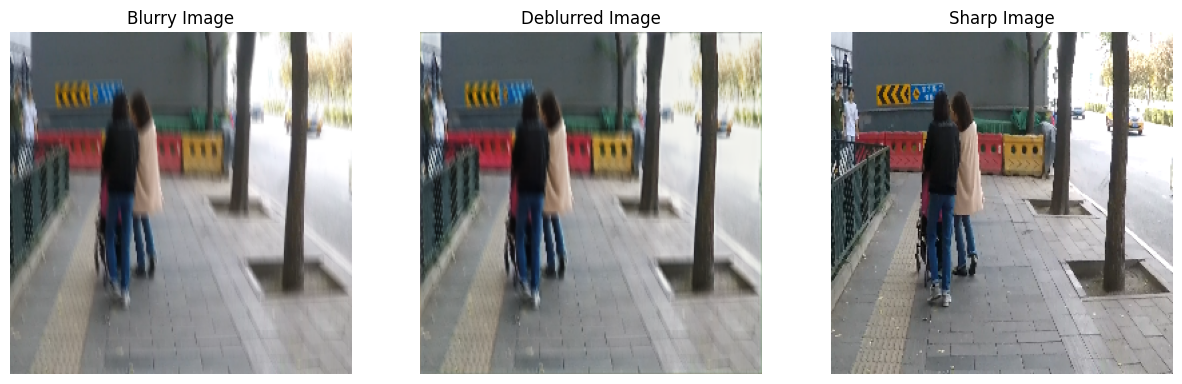

In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

IMG_SIZE = (256, 256)

# Function to load and preprocess an image
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return tf.expand_dims(image, axis=0)  # Add batch dimension

# Path to a test blurry image
test_image_path = "/kaggle/input/hideblur/HIDE_dataset/train/101fromGOPR1069.MP4.png"
sharp_image_path = "/kaggle/input/hideblur/HIDE_dataset/GT/101fromGOPR1069.MP4.png"
# Load and preprocess the test image
input_image = load_image(test_image_path)
# Predict using the model
output_image = model.predict(input_image)[0]  # Remove batch dimension
import numpy as np
import matplotlib.pyplot as plt

# Ensure the output image is in a valid format
output_image = np.clip(output_image, 0, 1)  # Ensure values are in [0,1]
output_image = (output_image * 255).astype(np.uint8)  # Convert to [0,255] uint8

# Ensure input image is in a valid format
input_image = input_image[0].numpy()  # Convert tensor to numpy
input_image = (input_image * 255).astype(np.uint8)  # Convert to uint8

# Load and preprocess the sharp ground truth image
sharp_image = load_image(sharp_image_path)

# Convert it to a displayable format
sharp_image = sharp_image[0].numpy()  # Convert tensor to numpy
sharp_image = (sharp_image * 255).astype(np.uint8)  # Convert to uint8

# Plot all three images
plt.figure(figsize=(15, 5))

# Original blurry image
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title("Blurry Image")
plt.axis("off")

# Deblurred output
plt.subplot(1, 3, 2)
plt.imshow(output_image)
plt.title("Deblurred Image")
plt.axis("off")

# Sharp Image (Ground Truth)
plt.subplot(1, 3, 3)
plt.imshow(sharp_image)
plt.title("Sharp Image")
plt.axis("off")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


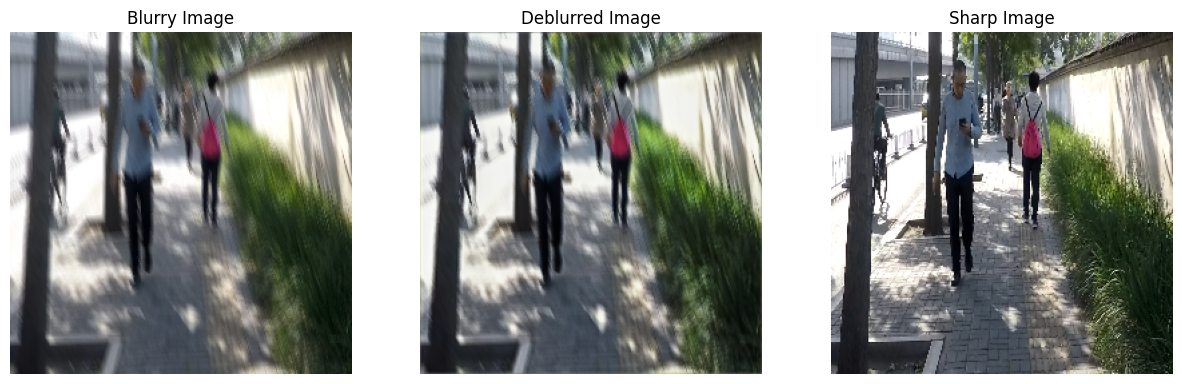

In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

IMG_SIZE = (256, 256)

# Function to load and preprocess an image
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return tf.expand_dims(image, axis=0)  # Add batch dimension

# Path to a test blurry image
test_image_path = "/kaggle/input/hideblur/HIDE_dataset/train/102fromGOPR1073.MP4.png"
sharp_image_path = "/kaggle/input/hideblur/HIDE_dataset/GT/102fromGOPR1073.MP4.png"
# Load and preprocess the test image
input_image = load_image(test_image_path)
# Predict using the model
output_image = model.predict(input_image)[0]  # Remove batch dimension
import numpy as np
import matplotlib.pyplot as plt

# Ensure the output image is in a valid format
output_image = np.clip(output_image, 0, 1)  # Ensure values are in [0,1]
output_image = (output_image * 255).astype(np.uint8)  # Convert to [0,255] uint8

# Ensure input image is in a valid format
input_image = input_image[0].numpy()  # Convert tensor to numpy
input_image = (input_image * 255).astype(np.uint8)  # Convert to uint8

# Load and preprocess the sharp ground truth image
sharp_image = load_image(sharp_image_path)

# Convert it to a displayable format
sharp_image = sharp_image[0].numpy()  # Convert tensor to numpy
sharp_image = (sharp_image * 255).astype(np.uint8)  # Convert to uint8

# Plot all three images
plt.figure(figsize=(15, 5))

# Original blurry image
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title("Blurry Image")
plt.axis("off")

# Deblurred output
plt.subplot(1, 3, 2)
plt.imshow(output_image)
plt.title("Deblurred Image")
plt.axis("off")

# Sharp Image (Ground Truth)
plt.subplot(1, 3, 3)
plt.imshow(sharp_image)
plt.title("Sharp Image")
plt.axis("off")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


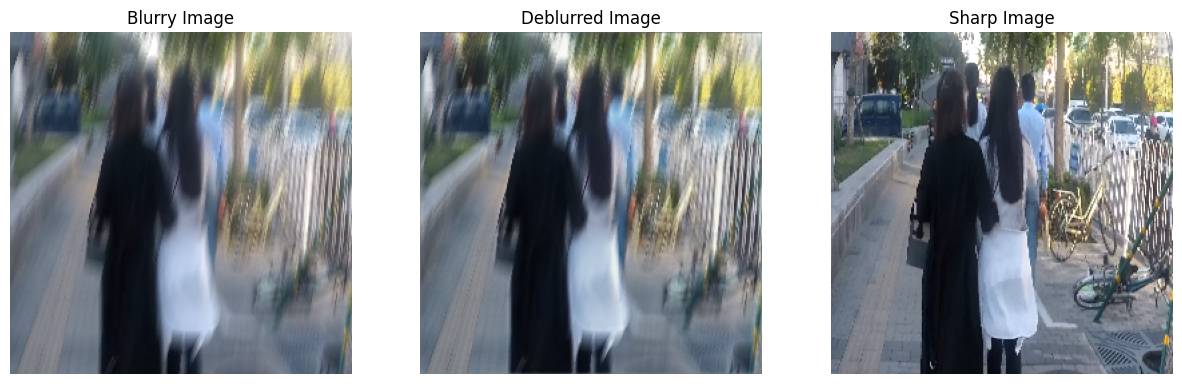

In [24]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

IMG_SIZE = (256, 256)

# Function to load and preprocess an image
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return tf.expand_dims(image, axis=0)  # Add batch dimension

# Function to test an image with the model
def test_deblurring(model, blurry_image_path, sharp_image_path):
    # Load and preprocess images
    input_image = load_image(blurry_image_path)
    sharp_image = load_image(sharp_image_path)
    
    # Predict using the model
    output_image = model.predict(input_image)[0]  # Remove batch dimension

    # Convert images to displayable format
    input_image = (input_image[0].numpy() * 255).astype(np.uint8)
    output_image = np.clip(output_image, 0, 1)  # Ensure values are in [0,1]
    output_image = (output_image * 255).astype(np.uint8)
    sharp_image = (sharp_image[0].numpy() * 255).astype(np.uint8)

    # Plot the images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.title("Blurry Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(output_image)
    plt.title("Deblurred Image")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(sharp_image)
    plt.title("Sharp Image")
    plt.axis("off")

    plt.show()

# Example usage
test_image_path = "/kaggle/input/hideblur/HIDE_dataset/train/103fromGOPR1086.MP4.png"
sharp_image_path = "/kaggle/input/hideblur/HIDE_dataset/GT/103fromGOPR1086.MP4.png"

test_deblurring(model, test_image_path, sharp_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


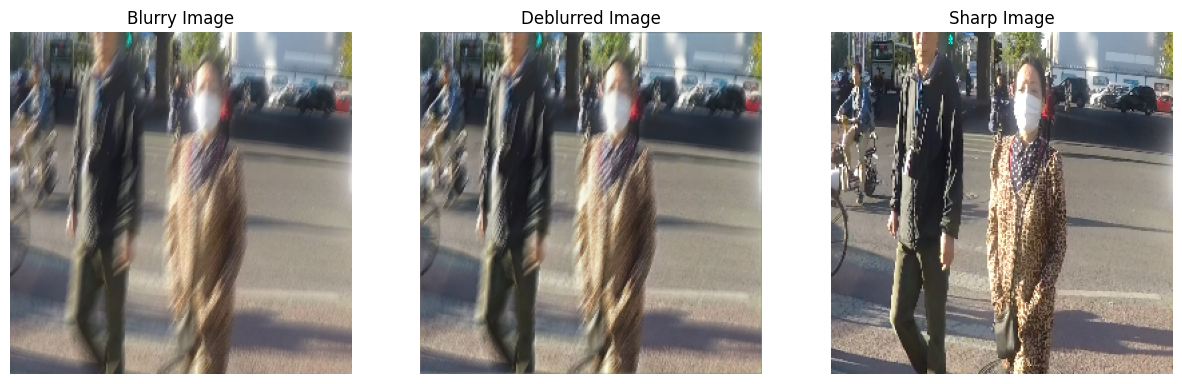

In [25]:
# Example usage
test_image_path = "/kaggle/input/hideblur/HIDE_dataset/train/105fromGOPR1082.MP4.png"
sharp_image_path = "/kaggle/input/hideblur/HIDE_dataset/GT/105fromGOPR1082.MP4.png"

test_deblurring(model, test_image_path, sharp_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


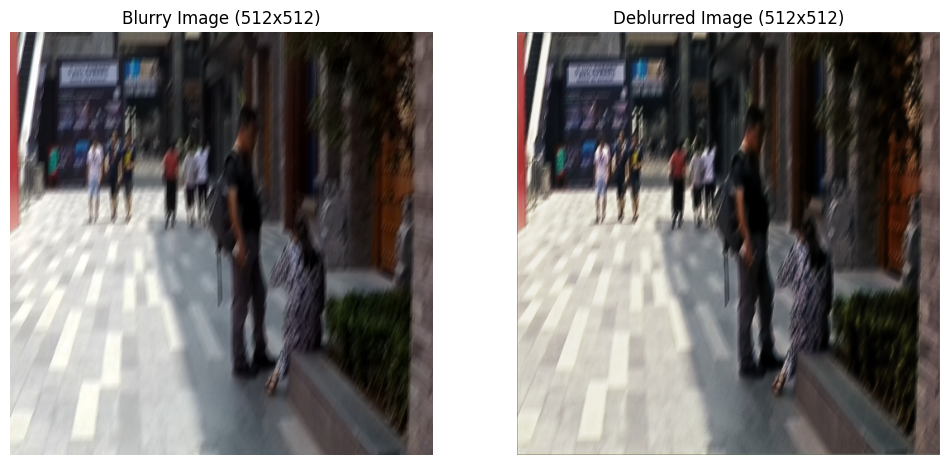

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set image size to 512x512
IMG_SIZE = (512, 512)

# Function to load and preprocess an image
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)  # Resize to 512x512
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return tf.expand_dims(image, axis=0)  # Add batch dimension

# Path to a test blurry image (update if needed)
test_image_path = "/kaggle/input/hideblur/HIDE_dataset/test/test-close-ups/106fromGOPR0955.png"

# Load and preprocess the test image
input_image = load_image(test_image_path)

# Predict using the trained model
output_image = model.predict(input_image)[0]  # Remove batch dimension

# Convert output image to uint8 for display
output_image = np.clip(output_image, 0, 1)  # Ensure values are in [0,1]
output_image = (output_image * 255).astype(np.uint8)  # Convert to [0,255] uint8

# Convert input image to uint8 for display
input_image = input_image[0].numpy()  # Convert tensor to numpy
input_image = (input_image * 255).astype(np.uint8)  # Convert to uint8

# Plot original vs deblurred image
plt.figure(figsize=(12, 6))  # Make the figure slightly larger

# Original blurry image
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title("Blurry Image (512x512)")
plt.axis("off")

# Deblurred output
plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title("Deblurred Image (512x512)")
plt.axis("off")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


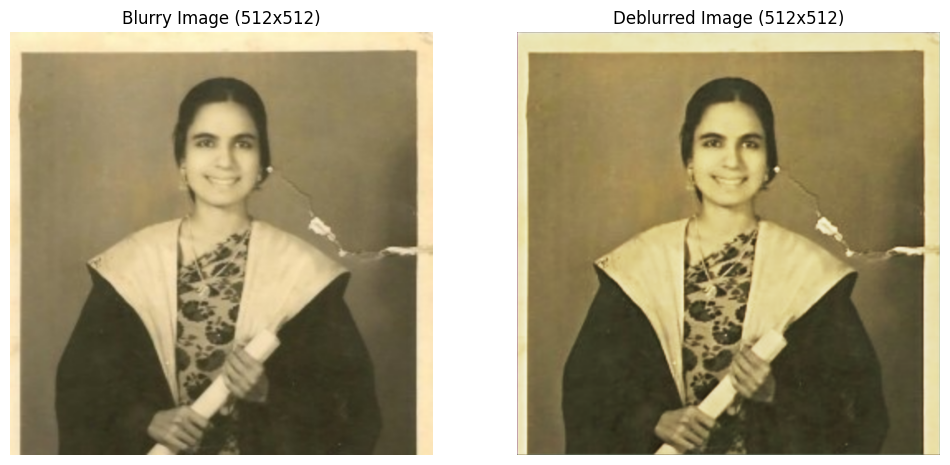

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set image size to 512x512
IMG_SIZE = (512, 512)

# Function to load and preprocess an image
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)  # Resize to 512x512
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return tf.expand_dims(image, axis=0)  # Add batch dimension

# Path to a test blurry image (update if needed)
test_image_path = "/kaggle/input/dadiji-test-scratched/dadiji_test_scratched.jpg"

# Load and preprocess the test image
input_image = load_image(test_image_path)

# Predict using the trained model
output_image = model.predict(input_image)[0]  # Remove batch dimension

# Convert output image to uint8 for display
output_image = np.clip(output_image, 0, 1)  # Ensure values are in [0,1]
output_image = (output_image * 255).astype(np.uint8)  # Convert to [0,255] uint8

# Convert input image to uint8 for display
input_image = input_image[0].numpy()  # Convert tensor to numpy
input_image = (input_image * 255).astype(np.uint8)  # Convert to uint8

# Plot original vs deblurred image
plt.figure(figsize=(12, 6))  # Make the figure slightly larger

# Original blurry image
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title("Blurry Image (512x512)")
plt.axis("off")

# Deblurred output
plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title("Deblurred Image (512x512)")
plt.axis("off")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


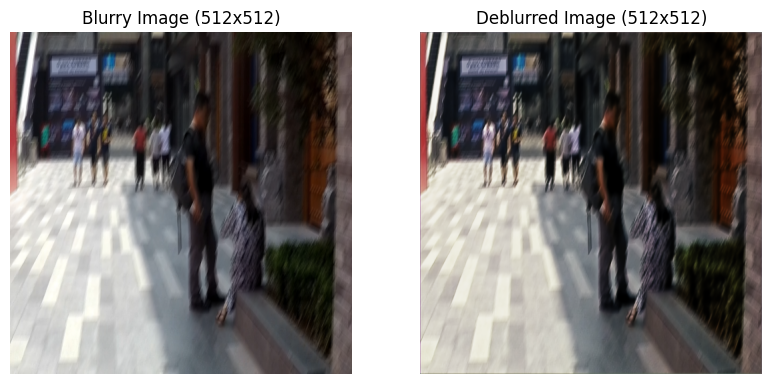

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set image size to 512x512
IMG_SIZE = (512, 512)

# Function to load and preprocess an image
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)  # Resize to 512x512
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return tf.expand_dims(image, axis=0)  # Add batch dimension

# Function to test an image with the model
def test_deblurring(model, blurry_image_path, sharp_image_path):
    # Load and preprocess images
    input_image = load_image(blurry_image_path)
    sharp_image = load_image(sharp_image_path)
    
    # Predict using the trained model
    output_image = model.predict(input_image)[0]  # Remove batch dimension

    # Convert images to displayable format (uint8)
    input_image = (input_image[0].numpy() * 255).astype(np.uint8)
    output_image = np.clip(output_image, 0, 1)  # Ensure values are in [0,1]
    output_image = (output_image * 255).astype(np.uint8)
    sharp_image = (sharp_image[0].numpy() * 255).astype(np.uint8)

    # Plot the images side by side
    plt.figure(figsize=(15, 5))  # Adjusted for better visibility

    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.title("Blurry Image (512x512)")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(output_image)
    plt.title("Deblurred Image (512x512)")
    plt.axis("off")

    # plt.subplot(1, 3, 3)
    # plt.imshow(sharp_image)
    # plt.title("Ground Truth (512x512)")
    # plt.axis("off")

    plt.show()

# Example usage: Update the file paths accordingly
test_image_path = "/kaggle/input/hideblur/HIDE_dataset/test/test-close-ups/106fromGOPR0955.png"
sharp_image_path = "/kaggle/input/hideblur/HIDE_dataset/GT/106fromGOPR0955.png"

test_deblurring(model, test_image_path, sharp_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


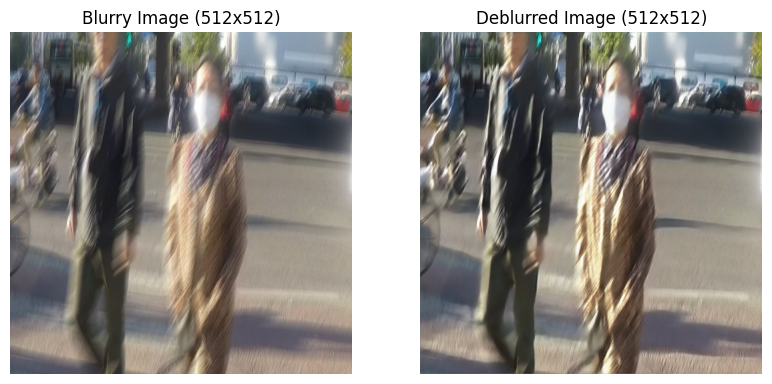

In [29]:
# Example usage
test_image_path = "/kaggle/input/hideblur/HIDE_dataset/train/105fromGOPR1082.MP4.png"
sharp_image_path = "/kaggle/input/hideblur/HIDE_dataset/GT/105fromGOPR1082.MP4.png"

test_deblurring(model, test_image_path, sharp_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


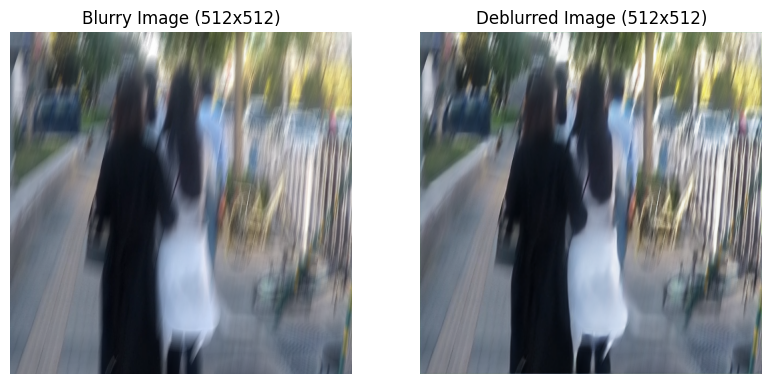

In [33]:
# Example usage
test_image_path = "/kaggle/input/hideblur/HIDE_dataset/train/103fromGOPR1086.MP4.png"
sharp_image_path = "/kaggle/input/hideblur/HIDE_dataset/GT/103fromGOPR1086.MP4.png"

test_deblurring(model, test_image_path, sharp_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


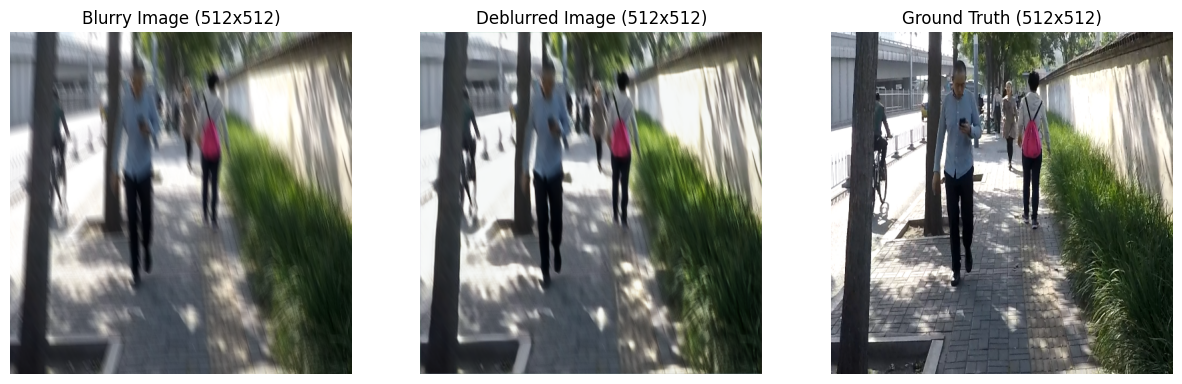

In [37]:
test_image_path = "/kaggle/input/hideblur/HIDE_dataset/train/102fromGOPR1073.MP4.png"
sharp_image_path = "/kaggle/input/hideblur/HIDE_dataset/GT/102fromGOPR1073.MP4.png"

test_deblurring(model, test_image_path, sharp_image_path)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Path to the uploaded model
model_path = "/kaggle/input/512_30epochs_kaggle_hideblur/keras/default/1/512_30Epochs_kaggle_best_deblur_model_512.keras"

# Load the model using MirroredStrategy to use both GPUs
strategy = tf.distribute.MirroredStrategy()
print(f"Using {strategy.num_replicas_in_sync} GPUs")

# Define SSIM Loss function (needed for custom loss)
def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# Load model inside strategy scope
with strategy.scope():
    model = load_model(model_path, custom_objects={'SSIMLoss': SSIMLoss})

print("Model loaded successfully!")


Using 2 GPUs
Model loaded successfully!


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 78 variables whereas the saved optimizer has 82 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Define checkpoint system to save the best model
checkpoint = ModelCheckpoint("/kaggle/working/best_deblur_model_512_v2.keras", 
                             monitor='loss', 
                             save_best_only=True, 
                             verbose=1)

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)

# Train dataset (reuse the existing dataset creation process)
epochs = 30
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()

# Train the model for 30 more epochs
with strategy.scope():
    model.fit(train_dataset, 
              epochs=epochs, 
              steps_per_epoch=steps_per_epoch, 
              callbacks=[checkpoint, reduce_lr])

# Save final model
model.save("/kaggle/working/512_60Epochs_Kaggle.keras")
print("Training completed and model saved!")


Epoch 1/30
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.8602 - loss: 0.2862
Epoch 1: loss improved from inf to 0.28488, saving model to /kaggle/working/best_deblur_model_512_v2.keras


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


125/125 ━━━━━━━━━━━━━━━━━━━━ 162s 571ms/step - accuracy: 0.8601 - loss: 0.2862 - learning_rate: 0.0010
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.8698 - loss: 0.2852
Epoch 2: loss improved from 0.28488 to 0.28168, saving model to /kaggle/working/best_deblur_model_512_v2.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 101s 583ms/step - accuracy: 0.8698 - loss: 0.2852 - learning_rate: 0.0010
Epoch 3/30

Epoch 3: loss improved from 0.28168 to 0.00000, saving model to /kaggle/working/best_deblur_model_512_v2.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.8663 - loss: 0.2818
Epoch 4: loss did not improve from 0.00000
125/125 ━━━━━━━━━━━━━━━━━━━━ 98s 559ms/step - accuracy: 0.8663 - loss: 0.2818 - learning_rate: 0.0010
Epoch 5/30

Epoch 5: loss did not improve from 0.00000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 76us/step - accuracy: 0.0000e+00 - loss: 0.0

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Path to the uploaded model
model_path = "/kaggle/working/best_deblur_model_512_v2.keras"

# Load the model using MirroredStrategy to use both GPUs
strategy = tf.distribute.MirroredStrategy()
print(f"Using {strategy.num_replicas_in_sync} GPUs")

# Define SSIM Loss function (needed for custom loss)
def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# Load model inside strategy scope
with strategy.scope():
    model = load_model(model_path, custom_objects={'SSIMLoss': SSIMLoss})

print("Model loaded successfully!")


Using 2 GPUs
Model loaded successfully!


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 78 variables whereas the saved optimizer has 82 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


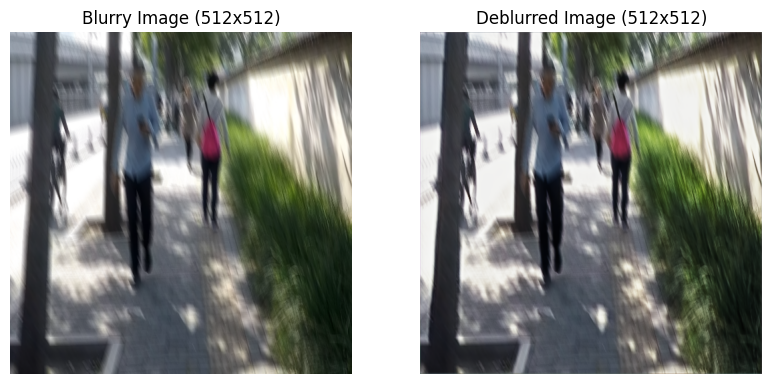

In [5]:
test_image_path = "/kaggle/input/hideblur/HIDE_dataset/train/102fromGOPR1073.MP4.png"
sharp_image_path = "/kaggle/input/hideblur/HIDE_dataset/GT/102fromGOPR1073.MP4.png"

test_deblurring(model, test_image_path, sharp_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


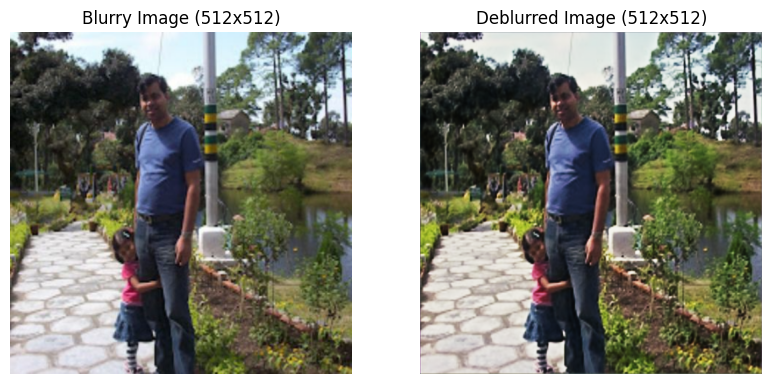

In [7]:
test_image_path = "/kaggle/input/photo-not-in-dataset/Photo_out_of_Blurry_Dataset.jpg"
sharp_image_path = "/kaggle/input/hideblur/HIDE_dataset/GT/102fromGOPR1073.MP4.png"

test_deblurring(model, test_image_path, sharp_image_path)